In [1]:
# %pip install python-dotenv
# %pip install seaborn
# %pip install tensorflow_data_validation

In [2]:
import os
import pandas as pd
import geopandas as gpd
import pygeos as pg
import numpy as np
import tensorflow as tf
import tensorflow_data_validation as tfdv
import sqlalchemy as sq
import sklearn as sk
import scipy as sp
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import clear_output
from matplotlib import pyplot as plt
from DataService import DataService

2022-12-01 02:15:09.484554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 02:15:09.817869: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# The following lines adjust the granularity of reporting.
#pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.chdir('/tf')
PGUSER = os.getenv('POSTGRES_USER')
PGPW = os.getenv('POSTGRES_PW')
PGDB = os.getenv('POSTGRES_DB')
NULLFLAG = -9999
ONEDAY = 24 * 60 * 60
WEEK = 7 * ONEDAY

In [4]:
# Connect to the database
pullService = DataService(PGDB, PGUSER, PGPW)
db_pull_con = pullService.connect()

pushService = DataService(PGDB, PGUSER, PGPW)
db_push_con = pushService.connect()

In [5]:
# load firewaterelev
fireWaterElev = "FireWaterElev"
query1 = "SELECT * FROM public.\"{}\";".format(fireWaterElev)
dfFireWaterElev = pd.read_sql(query1, db_pull_con)

In [6]:
print(dfFireWaterElev.count())
print(dfFireWaterElev.describe())
print(dfFireWaterElev.isnull().sum().sum())

EntryID          428
FIRE_ID          428
FIRENAME         428
YEAR             428
MONTH            428
DAY              428
REP_DATE         428
SIZE_HA          428
size_ha_bin      428
ClimateID        428
ElevationM       428
Dist_To_Water    428
utc              428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.0 428.0    428.0        428.0       428.0   
mean    3829.2 2013.9    6.8  15.9   8936.9          1.7       883.5   
std     3843.2    2.6    0.9   9.8  32731.6          1.1       460.7   
min       33.0 2010.0    5.0   1.0    200.7          0.0       334.0   
25%      757.5 2012.0    6.0   6.0    651.8          1.0       457.8   
50%     1736.0 2014.0    7.0  15.0   1880.7          2.0       787.5   
75%     8700.2 2016.0    7.0  25.2   5092.8          3.0      1280.0   
max    12248.0 2020.0   10.0  31.0 491429.4          3.0      1952.0   

       Dist_To_Water          utc  
count          428.0        4

In [7]:
# Load the data
fireWeather = "FireWeather"
query2 = "SELECT * FROM public.\"{}\";".format(fireWeather)
dfFireWeather = pd.read_sql(query2, db_pull_con)

In [8]:
print(dfFireWeather.count())
print(dfFireWeather.describe())
print(dfFireWeather.isnull().sum().sum())

EntryID                 428
FIRE_ID                 428
FIRENAME                428
YEAR                    428
MONTH                   428
DAY                     428
REP_DATE                428
SIZE_HA                 428
size_ha_bin             428
ClimateID               428
OneYear                 428
OneMonth                428
OneMeanTemp             428
OneMinTemp              428
OneMaxTemp              428
OneMeanDewPoint         428
OneMinDewPoint          428
OneMaxDewPoint          428
OneMeanHumidity         428
OneMinHumidity          428
OneMaxHumidity          428
OneMeanPressure         426
OneMinPressure          426
OneMaxPressure          426
OneMeanWindSpeed        426
OneMinWindSpeed         426
OneMaxWindSpeed         426
OneMeanWindChill        426
OneMinWindChill         426
OneMaxWindChill         426
OneTotalPrecip          428
OneMeanWindDirection    426
TwoYear                 428
TwoMonth                428
TwoMeanTemp             428
TwoMinTemp          

In [9]:
# Load WeatherDataHourlyAggDaily
weatherDataHourlyAggDaily = "WeatherDataHourlyAggDaily"
query3 = "SELECT * FROM public.\"{}\";".format(weatherDataHourlyAggDaily)
dfWeatherDaily = pd.read_sql(query3, db_pull_con)

In [10]:
print(dfWeatherDaily.count())
print(dfWeatherDaily.describe())
print(dfWeatherDaily.isnull().sum().sum())

ClimateID            72790
ProvinceCode         72790
Year                 72790
Month                72790
Day                  72790
MeanTemp             72790
MinTemp              72790
MaxTemp              72790
MeanDewPoint         71852
MinDewPoint          71852
MaxDewPoint          71852
MeanHumidity         71852
MinHumidity          71852
MaxHumidity          71852
MeanPressure         71487
MinPressure          71487
MaxPressure          71487
MeanWindSpeed        71487
MinWindSpeed         71487
MaxWindSpeed         71487
MeanWindChill        71487
MinWindChill         71487
MaxWindChill         71487
TotalPrecip          72790
MeanWindDirection    71487
utc                  72790
dtype: int64
         Year   Month     Day  MeanTemp  MinTemp  MaxTemp  MeanDewPoint  \
count 72790.0 72790.0 72790.0   72790.0  72790.0  72790.0       71852.0   
mean   2015.7     6.5    15.7      -0.4     -5.7      4.4          -5.6   
std       3.4     3.5     8.8      14.8     14.7     15.3   

Sums of max temp humidity days with precipitation in time period

In [11]:
dfFWEW = dfFireWaterElev.copy(deep=True)

In [12]:
# add 7 day sum max temp column, 7 day sum humidity column, 7 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '7daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '7daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '7daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [13]:
print(dfFWEW.count())
print(dfFWEW.describe())
print(dfFWEW.isnull().sum().sum())

EntryID            428
FIRE_ID            428
FIRENAME           428
YEAR               428
MONTH              428
DAY                428
REP_DATE           428
SIZE_HA            428
size_ha_bin        428
ClimateID          428
ElevationM         428
Dist_To_Water      428
utc                428
7daySumMaxTemp     428
7daySumHumidity    428
7daySumPrecip      428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.0 428.0    428.0        428.0       428.0   
mean    3829.2 2013.9    6.8  15.9   8936.9          1.7       883.5   
std     3843.2    2.6    0.9   9.8  32731.6          1.1       460.7   
min       33.0 2010.0    5.0   1.0    200.7          0.0       334.0   
25%      757.5 2012.0    6.0   6.0    651.8          1.0       457.8   
50%     1736.0 2014.0    7.0  15.0   1880.7          2.0       787.5   
75%     8700.2 2016.0    7.0  25.2   5092.8          3.0      1280.0   
max    12248.0 2020.0   10.0  31.0 491429.4

In [14]:
# add 14 day sum max temp column, 14 day sum humidity column, 14 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '14daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 2 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '14daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 2 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '14daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 2 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [15]:
# add 21 day sum max temp column, 21 day sum humidity column, 21 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '21daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 3 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '21daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 3 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '21daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 3 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [16]:
# add 28 day sum max temp column, 28 day sum humidity column, 28 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '28daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 4 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '28daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 4 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '28daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 4 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [17]:
# add 35 day sum max temp column, 35 day sum humidity column, 35 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '35daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 5 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '35daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 5 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '35daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 5 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [18]:
# add 42 day sum max temp column, 42 day sum humidity column, 42 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '42daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 6 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '42daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 6 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '42daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 6 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [19]:
# add 49 day sum max temp column, 49 day sum humidity column, 49 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '49daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 7 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '49daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 7 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '49daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 7 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [20]:
# add 56 day sum max temp column, 56 day sum humidity column, 56 day sum precip column
for index, row in dfFWEW.iterrows():
    dfFWEW.at[index, '56daySumMaxTemp'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 8 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxTemp'].sum()
    dfFWEW.at[index, '56daySumHumidity'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 8 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['MaxHumidity'].sum()
    dfFWEW.at[index, '56daySumPrecip'] = dfWeatherDaily.loc[(dfWeatherDaily['ClimateID'] == row['ClimateID']) & (dfWeatherDaily['utc'] >= (row['utc'] - 8 * WEEK)) & (dfWeatherDaily['utc'] <= row['utc'])]['TotalPrecip'].sum()

In [21]:
print(dfFWEW.count())
print(dfFWEW.describe())
print(dfFWEW.isnull().sum().sum())

EntryID             428
FIRE_ID             428
FIRENAME            428
YEAR                428
MONTH               428
DAY                 428
REP_DATE            428
SIZE_HA             428
size_ha_bin         428
ClimateID           428
ElevationM          428
Dist_To_Water       428
utc                 428
7daySumMaxTemp      428
7daySumHumidity     428
7daySumPrecip       428
14daySumMaxTemp     428
14daySumHumidity    428
14daySumPrecip      428
21daySumMaxTemp     428
21daySumHumidity    428
21daySumPrecip      428
28daySumMaxTemp     428
28daySumHumidity    428
28daySumPrecip      428
35daySumMaxTemp     428
35daySumHumidity    428
35daySumPrecip      428
42daySumMaxTemp     428
42daySumHumidity    428
42daySumPrecip      428
49daySumMaxTemp     428
49daySumHumidity    428
49daySumPrecip      428
56daySumMaxTemp     428
56daySumHumidity    428
56daySumPrecip      428
dtype: int64
       EntryID   YEAR  MONTH   DAY  SIZE_HA  size_ha_bin  ElevationM  \
count    428.0  428.0  428.

In [22]:
# group the fires with same utc and average the N day columns
dfFWEW = dfFWEW.groupby(['utc', 'YEAR', 'MONTH', 'DAY', 'ElevationM', 'Dist_To_Water'], as_index=False).agg({'SIZE_HA':['sum'],
                                                     '7daySumMaxTemp':['mean'], '7daySumHumidity':['mean'], '7daySumPrecip':['mean'],
                                                     '14daySumMaxTemp':['mean'], '14daySumHumidity':['mean'], '14daySumPrecip':['mean'],
                                                     '21daySumMaxTemp':['mean'], '21daySumHumidity':['mean'], '21daySumPrecip':['mean'],
                                                     '28daySumMaxTemp':['mean'], '28daySumHumidity':['mean'], '28daySumPrecip':['mean'],
                                                     '35daySumMaxTemp':['mean'], '35daySumHumidity':['mean'], '35daySumPrecip':['mean'],
                                                     '42daySumMaxTemp':['mean'], '42daySumHumidity':['mean'], '42daySumPrecip':['mean'],
                                                     '49daySumMaxTemp':['mean'], '49daySumHumidity':['mean'], '49daySumPrecip':['mean'],
                                                     '56daySumMaxTemp':['mean'], '56daySumHumidity':['mean'], '56daySumPrecip':['mean']})

In [23]:
print(dfFWEW.count())
print(dfFWEW.describe())
print(dfFWEW.isnull().sum().sum())

utc                       428
YEAR                      428
MONTH                     428
DAY                       428
ElevationM                428
Dist_To_Water             428
SIZE_HA           sum     428
7daySumMaxTemp    mean    428
7daySumHumidity   mean    428
7daySumPrecip     mean    428
14daySumMaxTemp   mean    428
14daySumHumidity  mean    428
14daySumPrecip    mean    428
21daySumMaxTemp   mean    428
21daySumHumidity  mean    428
21daySumPrecip    mean    428
28daySumMaxTemp   mean    428
28daySumHumidity  mean    428
28daySumPrecip    mean    428
35daySumMaxTemp   mean    428
35daySumHumidity  mean    428
35daySumPrecip    mean    428
42daySumMaxTemp   mean    428
42daySumHumidity  mean    428
42daySumPrecip    mean    428
49daySumMaxTemp   mean    428
49daySumHumidity  mean    428
49daySumPrecip    mean    428
56daySumMaxTemp   mean    428
56daySumHumidity  mean    428
56daySumPrecip    mean    428
dtype: int64
               utc   YEAR MONTH   DAY ElevationM Dist_To_

In [24]:
dfEval = dfFWEW

In [25]:
# randomly select 6 years from 2010-2019 for training
dfTrain = dfEval[dfEval['YEAR'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016])]
dfValidate = dfEval[dfEval['YEAR'].isin([2017, 2018])]
dfTest = dfEval[dfEval['YEAR'].isin([2019, 2020])]

In [26]:
# Store our random selection, run once
# randomTrain = "RandomTrain"
# dfTrain.to_sql(randomTrain, db_push_con, if_exists='replace', index=False)

# randomTest = "RandomTest"
# dfTest.to_sql(randomTest, db_push_con, if_exists='replace', index=False)

# randomValidate = "RandomValidate"
# dfValidate.to_sql(randomValidate, db_push_con, if_exists='replace', index=False)

78

In [27]:
trainStats = tfdv.generate_statistics_from_dataframe(dfTrain)

In [28]:
tfdv.visualize_statistics(trainStats)


In [29]:
schema = tfdv.infer_schema(statistics=trainStats)
tfdv.display_schema(schema=schema)


,Type,Presence,Valency,Domain
Feature name,,,,
"'(\'utc\', \'\')'",INT,required,,-
"'(\'YEAR\', \'\')'",INT,required,,-
"'(\'MONTH\', \'\')'",INT,required,,-
"'(\'DAY\', \'\')'",INT,required,,-
"'(\'ElevationM\', \'\')'",FLOAT,required,,-
"'(\'Dist_To_Water\', \'\')'",FLOAT,required,,-
"'(\'SIZE_HA\', \'sum\')'",FLOAT,required,,-
"'(\'7daySumMaxTemp\', \'mean\')'",FLOAT,required,,-
"'(\'7daySumHumidity\', \'mean\')'",FLOAT,required,,-


In [30]:
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


Y_train = dfTrain['SIZE_HA'].copy(deep=True)
Y_train.fillna(Y_train.mean(), inplace=True)

Y_train_discrete = dfTrain['size_ha_bin'].copy(deep=True)
Y_train_discrete.fillna(Y_train_discrete.min(), inplace=True)



X_train = dfTrain.drop(columns=['MONTH', 'SIZE_HA', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])
X_train.fillna(X_train.mean(), inplace=True)
X_train_one = X_train.drop(columns=['TwoMeanTemp', 'TwoMinTemp', 'TwoMaxTemp', 'TwoMeanDewPoint', 'TwoMinDewPoint', 'TwoMaxDewPoint',
                                     'TwoMeanHumidity', 'TwoMinHumidity', 'TwoMaxHumidity', 'TwoMeanPressure', 'TwoMinPressure',
                                     'TwoMaxPressure', 'TwoMeanWindSpeed', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMeanWindChill',
                                     'TwoMinWindChill', 'TwoMaxWindChill', 'TwoTotalPrecip', 'TwoMeanWindDirection'])
X_train_two = X_train.drop(columns=['OneMeanTemp', 'OneMinTemp', 'OneMaxTemp', 'OneMeanDewPoint', 'OneMinDewPoint', 'OneMaxDewPoint',
                                     'OneMeanHumidity', 'OneMinHumidity', 'OneMaxHumidity', 'OneMeanPressure', 'OneMinPressure',
                                     'OneMaxPressure', 'OneMeanWindSpeed', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMeanWindChill',
                                      'OneMinWindChill', 'OneMaxWindChill', 'OneTotalPrecip', 'OneMeanWindDirection'])

X_train_means_one = X_train_one.drop(columns=['OneMinTemp', 'OneMaxTemp', 'OneMinDewPoint', 'OneMaxDewPoint', 'OneMinHumidity', 'OneMaxHumidity',
                                              'OneMinPressure', 'OneMaxPressure', 'OneMinWindSpeed', 'OneMaxWindSpeed', 'OneMinWindChill',
                                              'OneMaxWindChill'])

X_train_means_two = X_train_two.drop(columns=['TwoMinTemp', 'TwoMaxTemp', 'TwoMinDewPoint', 'TwoMaxDewPoint', 'TwoMinHumidity', 'TwoMaxHumidity',
                                                'TwoMinPressure', 'TwoMaxPressure', 'TwoMinWindSpeed', 'TwoMaxWindSpeed', 'TwoMinWindChill',
                                                'TwoMaxWindChill'])

dfTrainScaled = dfTrain.copy(deep=True)
dfTrainScaled.fillna(dfTrainScaled.mean(), inplace=True)
dfTrainScaled = dfTrainScaled.drop(columns=['MONTH', 'OneMonth', 'OneYear', 'TwoMonth', 'TwoYear', 'EntryID', 'size_ha_bin', 'YEAR', 'DAY', 'FIRE_ID', 'FIRENAME', 'ClimateID', 'REP_DATE'])

# regularize y using log scale
Y_train = np.log(Y_train)
# regularize y values using z score
Y_train = (Y_train - Y_train.mean()) / Y_train.std()
# set max value to 3 zscore
Y_train[Y_train > 3] = 3

In [31]:
dfTrainScaled = dfTrain.copy(deep=True)

In [32]:
dfTrainScaled['SIZE_HA'] = np.log(dfTrainScaled['SIZE_HA'])
# regularize y values using z score
dfTrainScaled = (dfTrainScaled - dfTrainScaled.mean()) / dfTrainScaled.std()
# set max value to 3 zscore
dfTrainScaled[dfTrainScaled > 3] = 3
# set min value to -3 zscore
dfTrainScaled[dfTrainScaled < -3] = -3

# shift the wole train set to be positive
dfTrainScaled = dfTrainScaled + 3

In [33]:
trainStats2 = tfdv.generate_statistics_from_dataframe(dfTrainScaled)
tfdv.visualize_statistics(trainStats2)

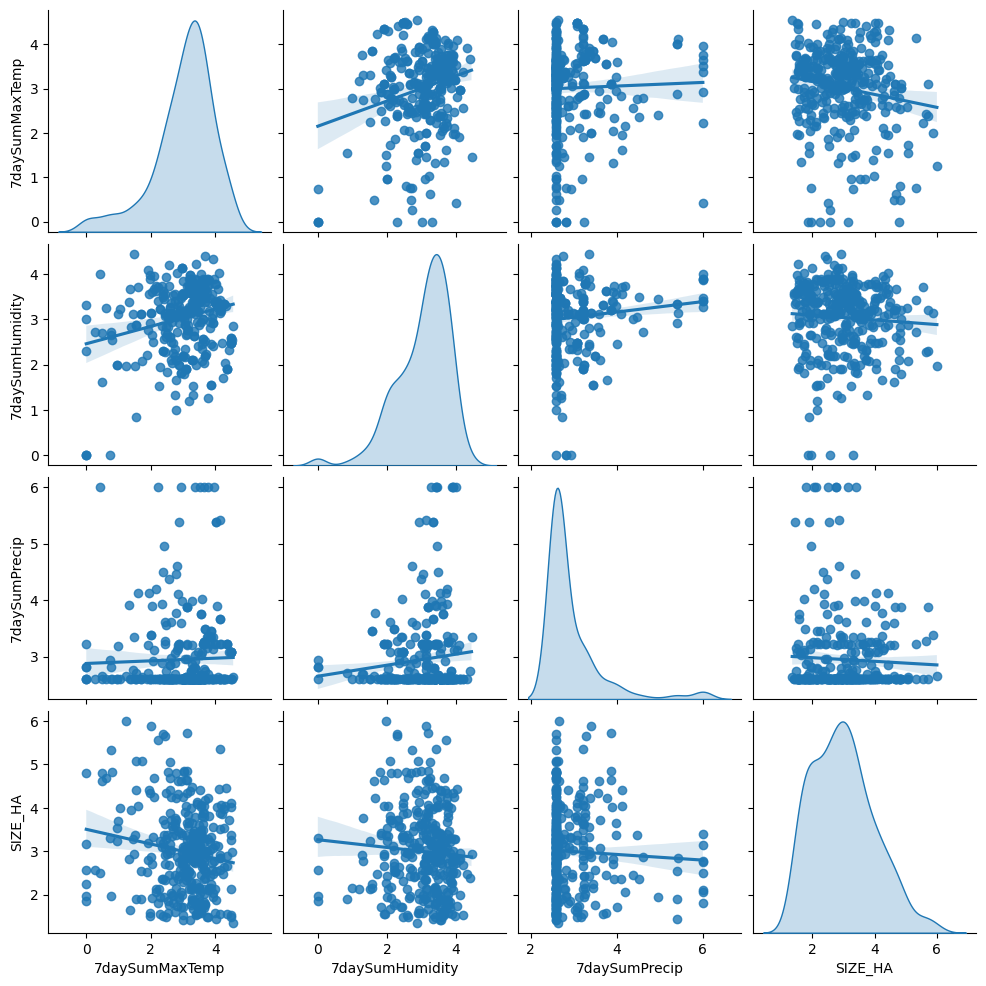

In [34]:
# one week data
weekData = pd.DataFrame()
train_dataset = dfTrainScaled.copy(deep=True)

# create a dataframe with the 7 day data
weekData['7daySumMaxTemp'] = train_dataset['7daySumMaxTemp']
weekData['7daySumHumidity'] = train_dataset['7daySumHumidity']
weekData['7daySumPrecip'] = train_dataset['7daySumPrecip']
weekData['SIZE_HA'] = train_dataset['SIZE_HA']


pairplotOne = sns.pairplot(weekData, kind="reg", diag_kind="kde")

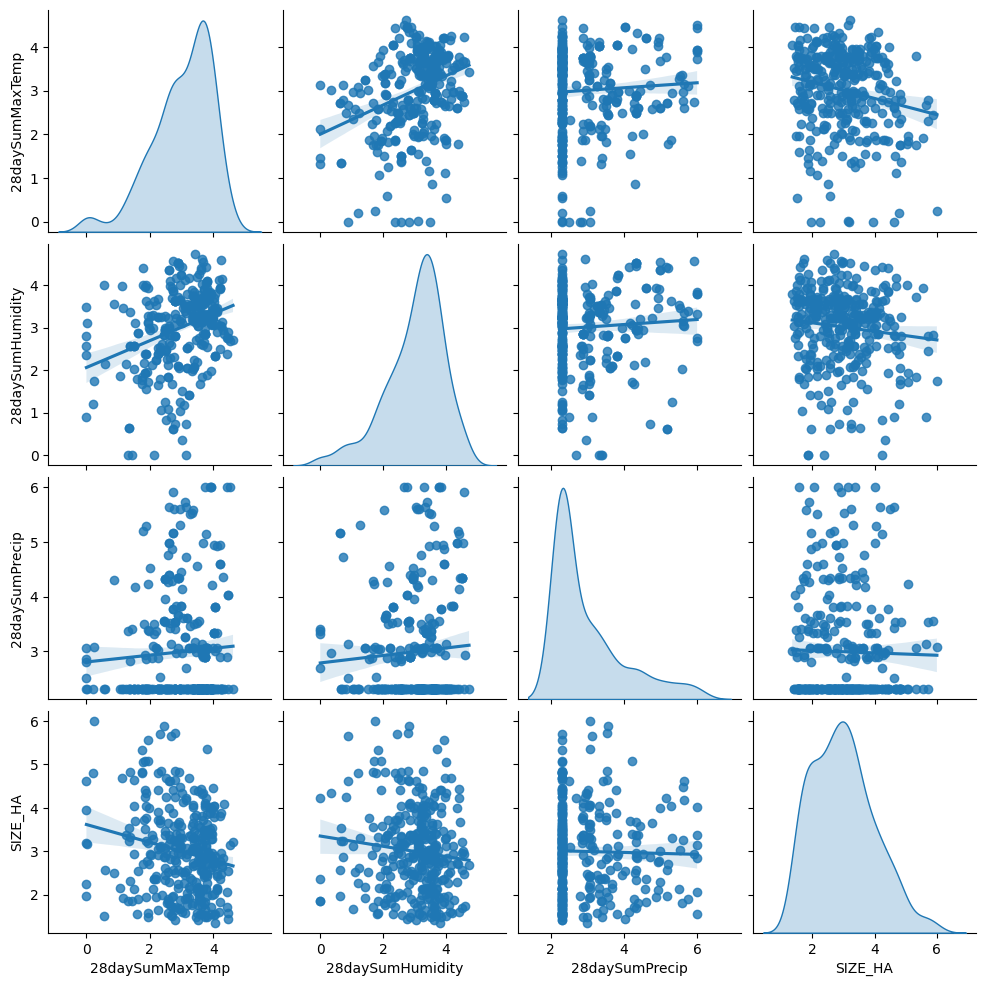

In [35]:
# one month data
monthData = pd.DataFrame()
train_dataset = dfTrainScaled.copy(deep=True)

# create a dataframe with the 28 day data
monthData['28daySumMaxTemp'] = train_dataset['28daySumMaxTemp']
monthData['28daySumHumidity'] = train_dataset['28daySumHumidity']
monthData['28daySumPrecip'] = train_dataset['28daySumPrecip']
monthData['SIZE_HA'] = train_dataset['SIZE_HA']

pairplotTwo = sns.pairplot(monthData, kind="reg", diag_kind="kde")

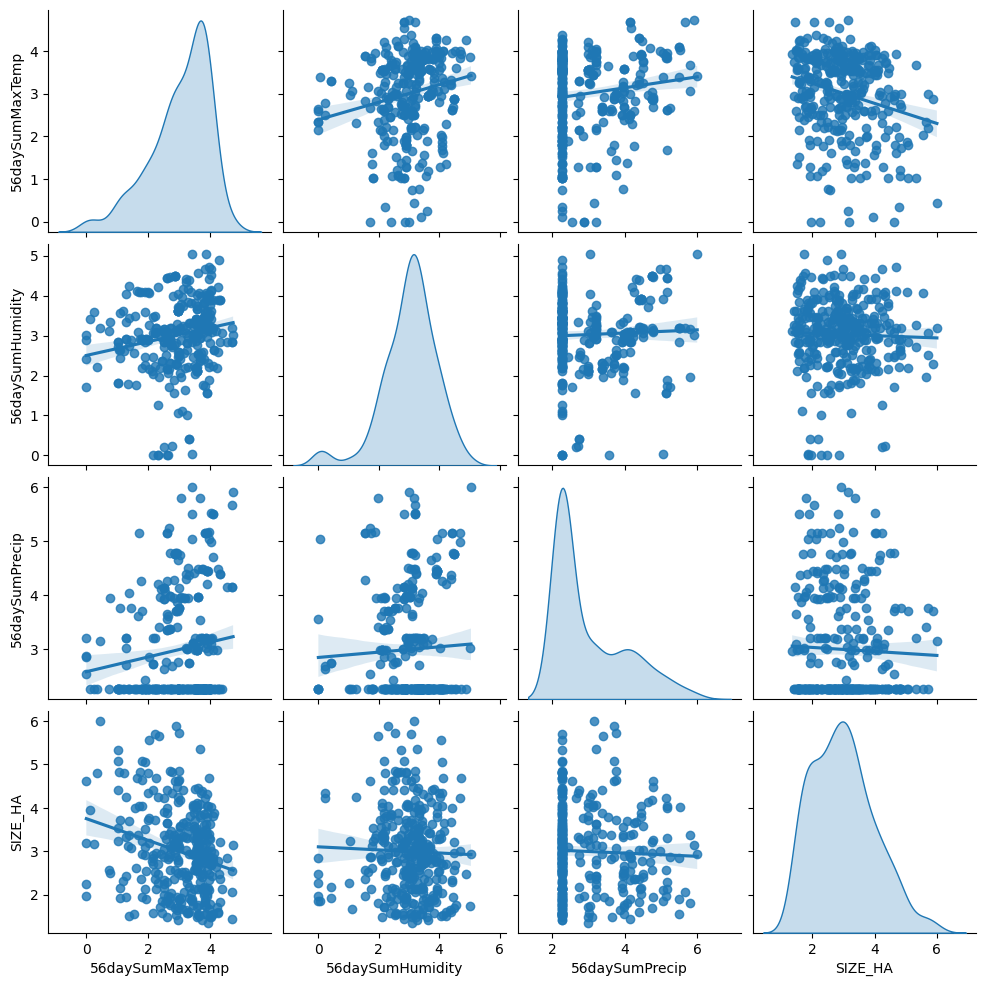

In [36]:
# two month data
twoMonthData = pd.DataFrame()
train_dataset = dfTrainScaled.copy(deep=True)

# create a dataframe with the 56 day data
twoMonthData['56daySumMaxTemp'] = train_dataset['56daySumMaxTemp']
twoMonthData['56daySumHumidity'] = train_dataset['56daySumHumidity']
twoMonthData['56daySumPrecip'] = train_dataset['56daySumPrecip']
twoMonthData['SIZE_HA'] = train_dataset['SIZE_HA']

pairplotThree = sns.pairplot(twoMonthData, kind="reg", diag_kind="kde")

In [37]:
dfTemp = pd.DataFrame()
dfTemp['SIZE_HA'] = dfTrainScaled['SIZE_HA'].copy(deep=True)
# categorize size_ha into 4 classes by quantile
dfTrainScaled['SIZE_BIN'] = pd.qcut(dfTemp['SIZE_HA'], 4, labels=False)

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(dfTrainScaled.drop(columns=['SIZE_HA']), dfTrainScaled['SIZE_BIN'])

In [38]:

print(dfTrainScaled.count())
print(dfTrainScaled.isna().sum().sum())
print(dfTrainScaled.dtypes)

utc                       336
YEAR                      336
MONTH                     336
DAY                       336
ElevationM                336
Dist_To_Water             336
SIZE_HA           sum     336
7daySumMaxTemp    mean    336
7daySumHumidity   mean    336
7daySumPrecip     mean    336
14daySumMaxTemp   mean    336
14daySumHumidity  mean    336
14daySumPrecip    mean    336
21daySumMaxTemp   mean    336
21daySumHumidity  mean    336
21daySumPrecip    mean    336
28daySumMaxTemp   mean    336
28daySumHumidity  mean    336
28daySumPrecip    mean    336
35daySumMaxTemp   mean    336
35daySumHumidity  mean    336
35daySumPrecip    mean    336
42daySumMaxTemp   mean    336
42daySumHumidity  mean    336
42daySumPrecip    mean    336
49daySumMaxTemp   mean    336
49daySumHumidity  mean    336
49daySumPrecip    mean    336
56daySumMaxTemp   mean    336
56daySumHumidity  mean    336
56daySumPrecip    mean    336
SIZE_BIN                  336
dtype: int64
0
utc                      

In [39]:
print(dfTrainScaled['ElevationM'].describe())
print(dfTrainScaled['28daySumMaxTemp'].describe())

count   336.0
mean      3.0
std       1.0
min       1.8
25%       2.1
50%       2.4
75%       3.9
max       5.4
Name: ElevationM, dtype: float64
       mean
count 336.0
mean    3.0
std     0.9
min     0.0
25%     2.5
50%     3.2
75%     3.7
max     4.6


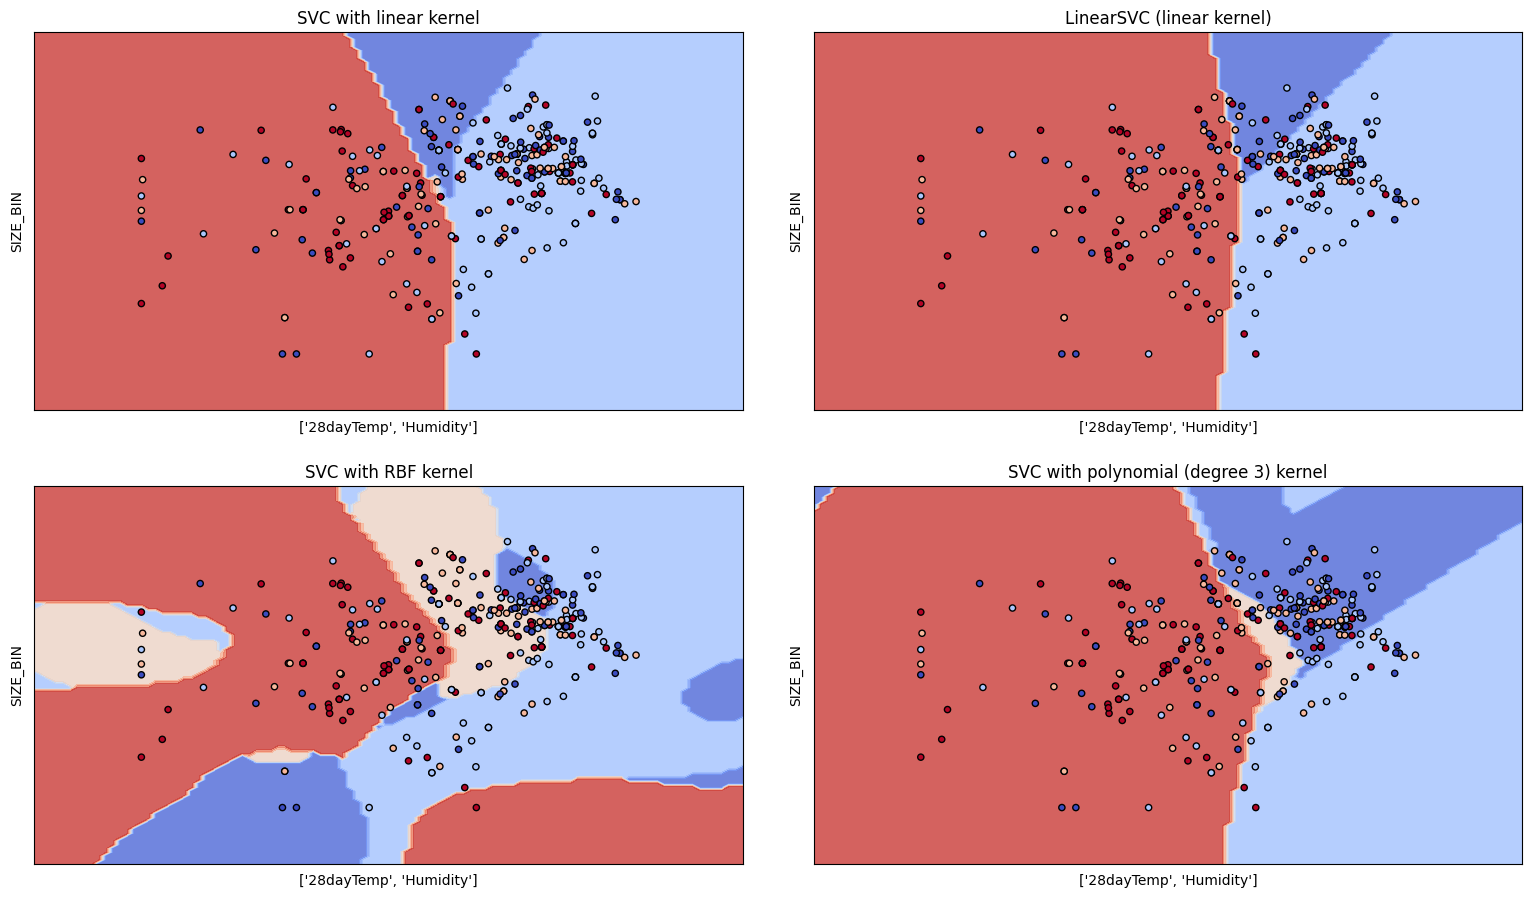

In [49]:
C = 1  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C, decision_function_shape='ovo'),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C, decision_function_shape='ovo'),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C, decision_function_shape='ovo'),
)
dfTemp = pd.DataFrame()
dfTemp['28daySumMaxTemp'] = dfTrainScaled['28daySumMaxTemp'].copy(deep=True)
dfTemp['28daySumHumidity'] = dfTrainScaled['28daySumHumidity'].copy(deep=True)

models = (clf.fit(dfTemp, dfTrainScaled['SIZE_BIN']) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2, figsize=(19.20, 10.80))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

X0 = dfTemp['28daySumMaxTemp'] 
X1 = dfTemp['28daySumHumidity']

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        dfTemp,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=['28dayTemp', 'Humidity'],
        ylabel="SIZE_BIN",
    )
    ax.scatter(X0, X1, c=dfTrainScaled['SIZE_BIN'], cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()